In [10]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set()

from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

from chord_functions import *

from sklearn.metrics import *
from sklearn.model_selection import KFold

# Setup

In [2]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

#Load all data
data = pd.read_csv('data/updated_with_R.csv')

#Remove redundant attributes. Need to keep op to split
data = data[['chord', 'op']]

#Tranform the chords using one-hot encoding before separation so train and test have same # of features
data = pd.get_dummies(data)

#Separate one opus for testing purposes
opus = 131
test = data.loc[data['op'] == opus]
train = data.loc[data['op'] != opus]

#Remove the opus feature
test = test.drop(columns='op')
train = train.drop(columns='op')

test = test.head(1000)
train = train.head(1000)

# Sequence generation

In [3]:
#Create input sequences of length 10, predict the 11:th
seq_length = 10

train_in, train_out = generate_sequences(train, train, seq_length)

test_in, test_out = generate_sequences(test, test, seq_length)

# Model

In [4]:
def lstm(lstm_x, lstm_y, optimizer, loss, metrics):
    model = Sequential()
    
    model.add(LSTM(256, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
    
    model.add(Dropout(0.5))
    
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    
    model.add(LSTM(64, return_sequences=False))
    
    model.add(Dropout(0.3))
    
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [5]:
#Define hyperparameters
optimizer = 'Adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

#Create model
model = lstm(train_in, train_out, optimizer, loss, metrics)

# Training

### Hyperparameters

In [6]:
cv_folds = 3
epochs = 25
verbose = 1

#Save the weights whenever validation accuracy is increased
checkpoint = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='val_acc', 
    verbose=0,        
    save_best_only=True
)
# Stop the learning process if we havent improved validation accuracy for 10 epochs
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1)
callbacks_list = [checkpoint, earlystop]     

### Cross validate

In [7]:
#Set up how to split the data
kf = KFold(n_splits=cv_folds, random_state=seed, shuffle=False)

model_storage = []
current_fold = 1

for train_fold, test_fold in kf.split(train_in):
    print("Current fold = {}".format(current_fold))
    current_fold += 1
    
    #Define the training fold
    train_x = train_in[train_fold]
    train_y = train_out[train_fold]
    
    #Define the test fold
    test_x = test_in[test_fold]
    test_y = test_out[test_fold]
    
    #Train on the folds
    model.fit(train_x,
              train_y,
              epochs = epochs,
              verbose = verbose,
              validation_data = (test_x, test_y),
              callbacks = callbacks_list)
    
    #Store the final model objects in a vector, one for each fold
    model_storage.append(model)

Current fold = 1
Train on 659 samples, validate on 330 samples
Epoch 1/25
659/659 [==============================] - 10s 15ms/step - loss: 4.1019 - acc: 0.0683 - val_loss: 3.9133 - val_acc: 0.0485
Epoch 2/25
659/659 [==============================] - 5s 7ms/step - loss: 3.6268 - acc: 0.0713 - val_loss: 3.9117 - val_acc: 0.1000
Epoch 3/25
659/659 [==============================] - 5s 7ms/step - loss: 3.5351 - acc: 0.0895 - val_loss: 3.9827 - val_acc: 0.0333
Epoch 4/25
659/659 [==============================] - 5s 7ms/step - loss: 3.5040 - acc: 0.0850 - val_loss: 4.0021 - val_acc: 0.1000
Epoch 5/25
659/659 [==============================] - 5s 7ms/step - loss: 3.5083 - acc: 0.0668 - val_loss: 4.0315 - val_acc: 0.1000
Epoch 6/25
659/659 [==============================] - 5s 7ms/step - loss: 3.4667 - acc: 0.0819 - val_loss: 4.0062 - val_acc: 0.1000
Epoch 7/25
659/659 [==============================] - 5s 7ms/step - loss: 3.4823 - acc: 0.0774 - val_loss: 4.0578 - val_acc: 0.1000
Epoch 00007

# Results

### Performance on test data

In [11]:
prob_dist = 0
for model in model_storage:   
    # Retrieve the probability distributions for the classes
    prob_dist += model.predict(test_in)
    
# Generate chord predictions from the average probability distribution
predicted = remap(prob_dist/cv_folds, test.columns.values)

# Generate actual from the test
actual = remap(test_out, test.columns.values)

print(classification_report(actual, predicted))

                precision    recall  f1-score   support

   chord_#viio       0.00      0.00      0.00         2
  chord_#viio2       0.00      0.00      0.00         7
 chord_#viio43       0.00      0.00      0.00         4
  chord_#viio6       0.00      0.00      0.00         2
  chord_#viio7       0.00      0.00      0.00         2
chord_#viio7/V       0.00      0.00      0.00         1
   chord_.Ger6       0.00      0.00      0.00         7
    chord_.It6       0.00      0.00      0.00         1
    chord_.bII       0.00      0.00      0.00         4
   chord_.bII6       0.00      0.00      0.00         2
    chord_.bVI       0.00      0.00      0.00         1
   chord_.bVII       0.00      0.00      0.00         1
   chord_@none       0.00      0.00      0.00         4
       chord_I       0.00      0.00      0.00       128
      chord_I6       0.05      1.00      0.10        50
     chord_I64       0.00      0.00      0.00         9
     chord_III       0.00      0.00      0.00  

/home/sigis/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Learning Curves

Final values
acc
0.09393939398454898
valacc
0.05167173252279635
loss
3.593551728219697
valoss
3.3906612831046155

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 256)           339968    
_________________________________________________________________
dropout (Dropout)            (None, 10, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 256)           394240    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 75)                4875      
Total params: 821,259
Traina

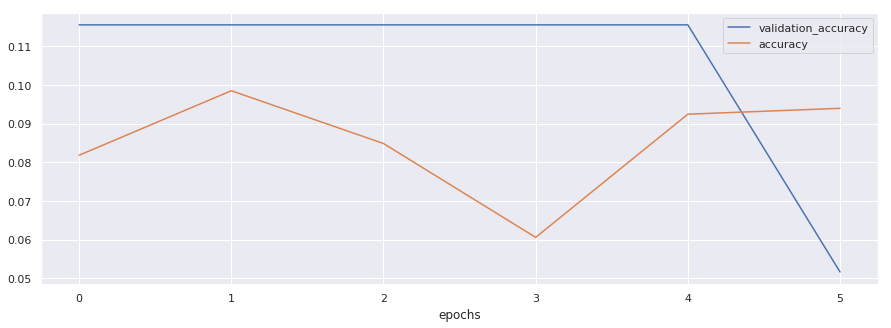

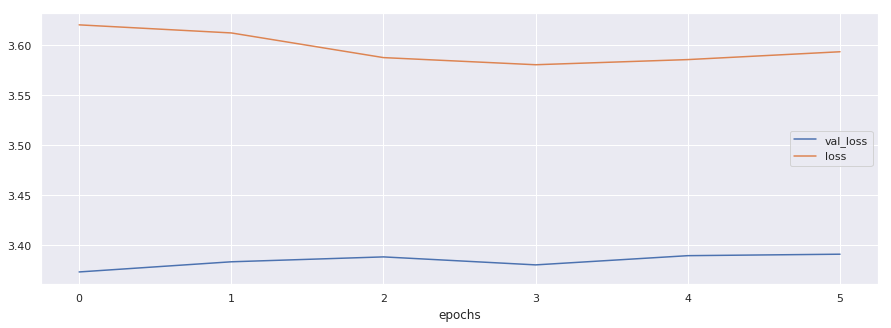

Final values
acc
0.09393939398454898
valacc
0.05167173252279635
loss
3.593551728219697
valoss
3.3906612831046155

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 256)           339968    
_________________________________________________________________
dropout (Dropout)            (None, 10, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 256)           394240    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 75)                4875      
Total params: 821,259
Traina

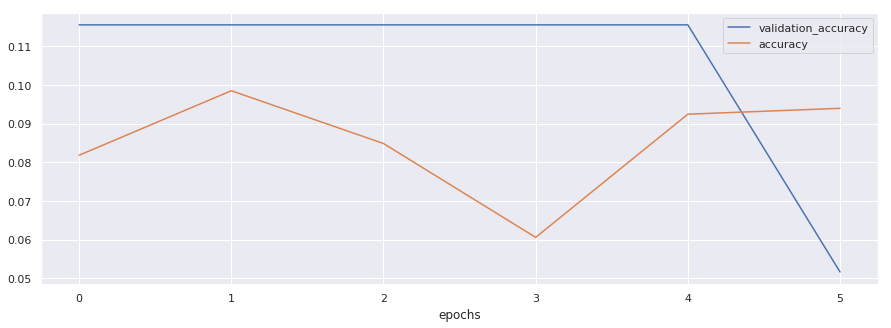

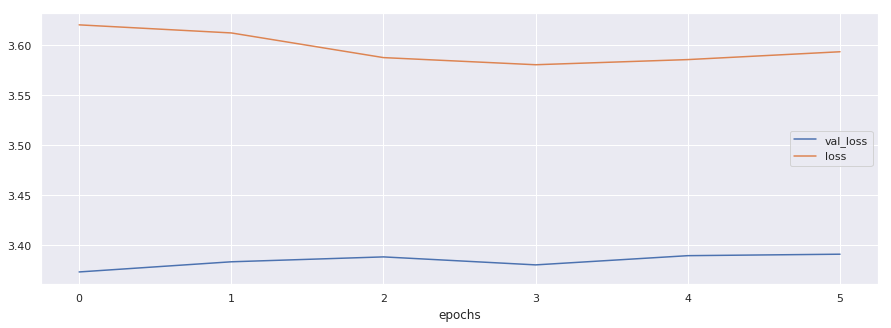

Final values
acc
0.09393939398454898
valacc
0.05167173252279635
loss
3.593551728219697
valoss
3.3906612831046155

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 256)           339968    
_________________________________________________________________
dropout (Dropout)            (None, 10, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 256)           394240    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 75)                4875      
Total params: 821,259
Traina

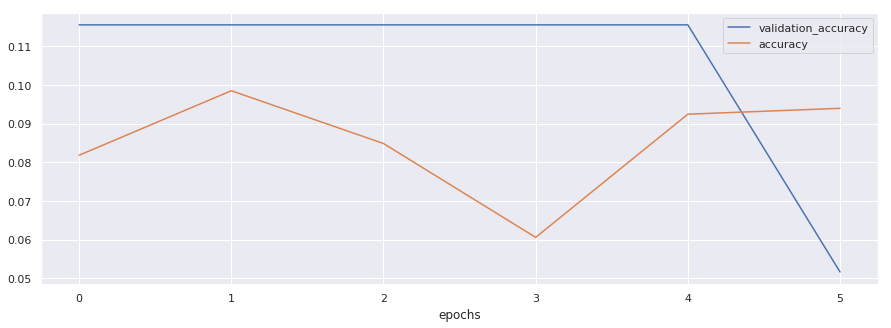

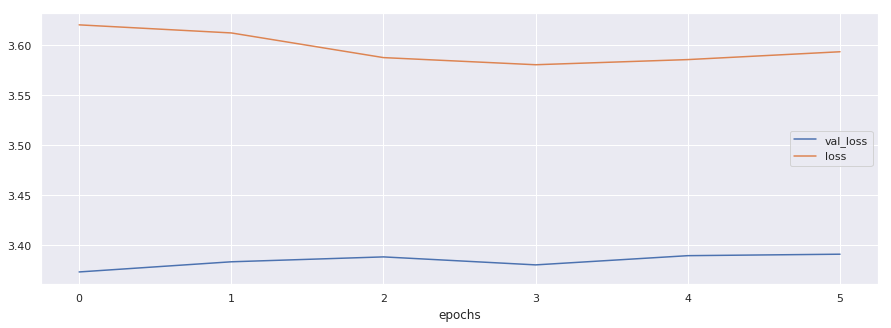

In [12]:
def disp_results(model_vector):
    """
    Takes a model vector plots the evolution of the metrics as well as the final scores for each model
    """
    for model in model_vector:     
        history = model.history
        df = pd.DataFrame({'epochs': history.epoch,
                           'accuracy': history.history['acc'],
                           'validation_accuracy': history.history['val_acc'],
                           'loss': history.history['loss'], 
                           'val_loss': history.history['val_loss']})


        #Plot the the scores on the validation and training sets
        df.plot(x='epochs', y = ['validation_accuracy','accuracy'], figsize=[15,5])
        df.plot(x='epochs', y = ['val_loss','loss'], figsize=[15,5])

        a = history.history['acc'][-1]
        va= history.history['val_acc'][-1]
        l = history.history['loss'][-1]
        vl= history.history['val_loss'][-1]

        print("Final values\nacc\n{}\nvalacc\n{}\nloss\n{}\nvaloss\n{}\n".format(a, va, l, vl))
        plt.show()
    
disp_results(model_storage)

## Confusion Matrix for Predictions

In [ ]:
c = confusion_matrix(actual, predicted)

fig, ax = plt.subplots(figsize = (25,25))
sns.heatmap(c, annot=False,  annot_kws={"size": 20}, fmt='d', cbar=True)
ax.set_title('Confusion matrix')
ax.set_xticklabels(test.columns.values, fontsize=12, rotation=90)
ax.set_yticklabels(test.columns.values, fontsize=12, rotation=0)
ax.set_xlabel('Predicted outcome', fontsize=16)
ax.set_ylabel('True outcome', fontsize=16)
plt.show()

## Comparison with human performance